In [1]:
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics import mean_squared_error
from keras.initializers import RandomNormal
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.models import Model,Sequential
from keras.layers import *
from keras import backend as K
from keras.models import model_from_json
from matplotlib import cm as CM
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import scipy.io as io
from PIL import Image
import PIL
import h5py
import os
import glob
import cv2
import random
import math
import sys

Using TensorFlow backend.


In [2]:
K.clear_session()
root = 'data'

In [3]:
train_image_dir = os.path.join(root, 'frames', 'train_data', 'images')
test_image_dir = os.path.join(root, 'frames', 'test_data', 'images')
temp = 'test_images'
path_sets = [train_image_dir]

In [4]:
img_paths = []

for path in path_sets:
    
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        img_paths.append(str(img_path))
        
print("Total images : ",len(img_paths))

Total images :  1600


In [5]:
# calculating mean and standard deviation of each channels

# Load the images into a 4D NumPy array
# images = np.array([cv2.imread(path) for path in img_paths])

# # Compute the channel-wise mean and standard deviation
# means = np.mean(images, axis=(0, 1, 2)) / 255.0
# stddevs = np.std(images, axis=(0, 1, 2)) / 255.0

# print("Means:", means)
# print("Standard deviations:", stddevs)



In [6]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.414)/0.206
    im[:,:,1]=(im[:,:,1]-0.462)/0.217
    im[:,:,2]=(im[:,:,2]-0.540)/0.221

    #print(im.shape)
    #im = np.expand_dims(im,axis  = 0)
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)
    
    
    
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    img = np.expand_dims(img,axis  = 3)
    
    #print(img.shape)
    
    return img
    
    
    
def preprocess_input(image,target):
    #crop image
    #crop target
    #resize target
    crop_size = (int(image.shape[0]/2),int(image.shape[1]/2))
    
    
    if random.randint(0,9)<= -1:            
            dx = int(random.randint(0,1)*image.shape[0]*1./2)
            dy = int(random.randint(0,1)*image.shape[1]*1./2)
    else:
            dx = int(random.random()*image.shape[0]*1./2)
            dy = int(random.random()*image.shape[1]*1./2)

    #print(crop_size , dx , dy)
    img = image[dx : crop_size[0]+dx , dy:crop_size[1]+dy]
    
    target_aug = target[dx:crop_size[0]+dx,dy:crop_size[1]+dy]
    #print(img.shape)

    return(img,target_aug)
    
   

In [7]:
#Image data generator 
def image_generator(files, batch_size = 64):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size)
        
        batch_input = []
        batch_output = [] 
          
        #for input_path in batch_paths:
        
        inputt = get_input(input_path )
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','ground') )
            
       
        batch_input += [inputt]
        batch_output += [output]
    

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )


In [8]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [9]:
def init_weights_vgg(model):
    #vgg =  VGG16(weights='imagenet', include_top=False)
    
    json_file = open('models/VGG_16.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("weights/VGG_16.h5")
    
    vgg = loaded_model
    
    vgg_weights=[]                         
    for layer in vgg.layers:
        if('conv' in layer.name):
            vgg_weights.append(layer.get_weights())
    
    
    offset=0
    i=0
    while(i<10):
        if('conv' in model.layers[i+offset].name):
            model.layers[i+offset].set_weights(vgg_weights[i])
            i=i+1
            #print('h')
            
        else:
            offset=offset+1

    return (model)
    

In [10]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=[1,2,3]))


In [11]:
# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            
            #Batch Normalisation option
            
            batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            model = Sequential() 
            
            #custom VGG:
            
            if(batch_norm):
                model.add(Conv2D(64, kernel_size = kernel, input_shape = (rows,cols,3),activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same'))
                model.add(BatchNormalization())
                
            else:
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, 3), kernel_initializer = init))
                model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
                model.add(MaxPooling2D(strides=2))            
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                

                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same'))
        
            sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
            model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
            
            model = init_weights_vgg(model)
            
            return model

In [12]:
model = CrowdNet()

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 256)   295168    
__________

In [14]:
train_gen = image_generator(img_paths, 32)

In [17]:
x_img, y_img = next(train_gen)

c:\Users\asus\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [ ]:
# sgd = SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
# model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])

In [15]:
history = model.fit_generator(train_gen,epochs=50,steps_per_epoch=1600//32 , verbose=1)

Epoch 1/50


c:\Users\asus\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


50/50 [==============================] - 223s 4s/step - loss: 1.5385 - mean_squared_error: 5.2559e-04
Epoch 2/50
50/50 [==============================] - 232s 5s/step - loss: 1.4337 - mean_squared_error: 4.6345e-04
Epoch 3/50
50/50 [==============================] - 252s 5s/step - loss: 1.4751 - mean_squared_error: 4.9597e-04
Epoch 4/50
50/50 [==============================] - 239s 5s/step - loss: 1.4945 - mean_squared_error: 5.1495e-04
Epoch 5/50
50/50 [==============================] - 234s 5s/step - loss: 1.5542 - mean_squared_error: 5.5850e-04
Epoch 6/50
50/50 [==============================] - 231s 5s/step - loss: 1.5212 - mean_squared_error: 5.1394e-04
Epoch 7/50
50/50 [==============================] - 232s 5s/step - loss: 1.4706 - mean_squared_error: 4.9503e-04
Epoch 8/50
50/50 [==============================] - 235s 5s/step - loss: 1.4223 - mean_squared_error: 4.4048e-04
Epoch 9/50
50/50 [==============================] - 238s 5s/step - loss: 1.4626 - mean_squared_error: 4.798

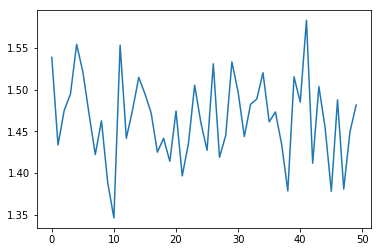

In [18]:
plt.plot(history.history["loss"])

In [20]:
save_mod(model,"weights/model_mall_weights_50_epoch.h5","models/Model_mall_50_epoch.json")

TypeError: 'History' object is not subscriptable